## Benchmarking L2G predictions

The objective of this notebook is to compare the new implementation of L2G with the last results we display in production (22.09.1).

The notebook is divided in 3 parts:
1. Data preparation
2. Describe the data
3. Compare the results


In [1]:
from datetime import datetime

import pyspark.sql.functions as f
import wandb
from pyspark.sql import DataFrame

from gentropy.common.session import Session
from gentropy.dataset.l2g_prediction import L2GPrediction
from gentropy.dataset.study_locus import StudyLocus

%matplotlib inline

session = Session(spark_uri="local[*]")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/12/11 16:18:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Data preparation

In [6]:
def prepare_predictions(credible_set: StudyLocus, predictions: L2GPrediction) -> DataFrame:
        """Prepares predictions dataframe for testing and comparison."""
        return (
                credible_set.df
                .select("studyLocusId", "variantId", "studyId").distinct()
                .join(
                        predictions.df, on="studyLocusId"
                )
                .select("studyLocusId", "variantId", "studyId", "geneId", "score")
                .distinct()
        )

def prepare_production_predictions(old_predictions: DataFrame) -> DataFrame:
        """Prepares L2G predictions for testing and comparison."""
        return (
                old_predictions
                .select(
                        f.col("study_id").alias("studyId"),
                        f.concat_ws("_", f.col("chrom"), f.col("pos"), f.col("ref"), f.col("alt")).alias("variantId"),
                        f.col("gene_id").alias("geneId"),
                        f.col("y_proba_full_model").alias("score"),
                )
                .withColumn("studyLocusId", StudyLocus.assign_study_locus_id(f.col("studyId"), f.col("variantId")))
                .distinct()
        )

In [2]:
# RAW DATA
credible_set_path = "gs://genetics_etl_python_playground/output/python_etl/parquet/XX.XX/credible_set"
predictions_path = "gs://genetics_etl_python_playground/output/python_etl/parquet/XX.XX/l2g_predictions"
old_predictions_path = "gs://genetics-portal-dev-data/22.09.1/outputs/l2g"

predictions = L2GPrediction.from_parquet(session, predictions_path)
old_predictions = session.spark.read.parquet(old_predictions_path)
credible_set = StudyLocus.from_parquet(session, credible_set_path, recursiveFileLookup=True)

In [7]:
predictions_prepared = prepare_predictions(credible_set, predictions).persist()
old_predictions_prepared = prepare_production_predictions(old_predictions).persist()

joining_cols = ["studyLocusId", "geneId", "variantId", "studyId"]
comparison_df = (
                predictions_prepared.selectExpr(*joining_cols, "score as new_score")
                .join(
                        old_predictions_prepared.selectExpr(*joining_cols, "score as old_score"), on=joining_cols, how="inner"
                )
                .distinct()
                .persist()
        )

comparison_output_path = f"gs://ot-team/irene/l2g_results_comparison-{datetime.today().strftime('%Y-%m-%d')}"
# comparison_df.write.parquet("gs://ot-team/irene/l2g_results_comparison")

## Data description

Note: Comparison_df is the result of intersecting the L2G datasets with both the production and the new implementation.

In [8]:
## 1. L2G predicted credible sets count

datasets = {
    "predictions_prepared": predictions_prepared,
    "old_predictions_prepared": old_predictions_prepared,
    "comparison_df": comparison_df
}

print("COUNT PER DATASET")
for dataset in datasets.items():
    print(f"{dataset[0]}: {dataset[1].count()}")


COUNT PER DATASET


predictions_prepared: 9061746


old_predictions_prepared: 4083797


comparison_df: 2194371


In [19]:
## 2. Descriptive stats for L2G scores

print("AVERAGE SCORES PER DATASET")
for dataset in datasets.items():
    if dataset[0] != "comparison_df":
        print(f"{dataset[0]}: {dataset[1].agg(f.avg('score')).collect()[0][0]}")

print("MEDIAN SCORE PER DATASET")
for dataset in datasets.items():
    if dataset[0] != "comparison_df":
        print(f"{dataset[0]}: {dataset[1].approxQuantile('score',[0.5],0.1)[0]}")


AVERAGE SCORES PER DATASET


predictions_prepared: 0.20072320074989783


old_predictions_prepared: 0.0720378814046517
MEDIAN SCORE PER DATASET


predictions_prepared: 0.023215007036924362


old_predictions_prepared: 0.012324056588113308


In [20]:
## How many associations with a score > 0.9

print("# OF ASSOCIATIONS WITH SCORE > 0.9")
for dataset in datasets.items():
    if dataset[0] != "comparison_df":
        print(f"{dataset[0]}: {dataset[1].filter(f.col('score') >= 0.9).count()} ({round(dataset[1].filter(f.col('score') >= 0.9).count()/dataset[1].count() * 100, 2)} from total)")


# OF ASSOCIATIONS WITH SCORE > 0.9


predictions_prepared: 5275 (0.06 from total)
old_predictions_prepared: 3942 (0.1 from total)


## Results comparison

The comparisons dataset represents the intersection of the predictions of the production and the new implementation. The objective is to compare the L2G scores of both implementations for the same studyLoci.

In [27]:
comparison_pdf = comparison_df.toPandas()
comparison_pdf.head()

,studyLocusId,geneId,variantId,studyId,new_score,old_score
0,-9221872607204368224,ENSG00000065717,19_3414090_G_A,GCST010241,0.001887,0.008250
1,-9219397145747036852,ENSG00000168056,11_65619907_T_A,GCST007234,0.038177,0.014908
2,-9219397145747036852,ENSG00000175376,11_65619907_T_A,GCST007234,0.015846,0.011380
3,-9217975156633736203,ENSG00000187475,6_26325235_T_C,GCST009456,0.039668,0.010985
4,-9216978755013122322,ENSG00000157617,21_41816125_G_A,GCST005945,0.271009,0.024520


In [36]:
## Correlation between old and new scores

overall_corr = comparison_pdf["old_score"].corr(comparison_pdf["new_score"])
print("SCORES CORRELATION", overall_corr)

print("Split by chromosome...")

comparison_pdf["chromosome"] = comparison_pdf["variantId"].str.split("_", expand=True)[0]

for group in comparison_pdf.sort_values("chromosome").groupby("chromosome"):
    corr = group[1]["old_score"].corr(group[1]["new_score"])
    print(f"Chromosome {group[0]}: {corr}")

SCORES CORRELATION 0.3968047070256464
Split by chromosome...
Chromosome 1: 0.4283002148537705
Chromosome 10: 0.4548083324805242
Chromosome 11: 0.3952137911268187
Chromosome 12: 0.4185634370780096
Chromosome 13: 0.42117917239984404
Chromosome 14: 0.39845735792304493
Chromosome 15: 0.40346861517903765
Chromosome 16: 0.39846240000598415
Chromosome 17: 0.395304979654295
Chromosome 18: 0.41437506238370103
Chromosome 19: 0.4425118135710343
Chromosome 2: 0.3889598461816933
Chromosome 20: 0.43686865328167446
Chromosome 21: 0.3849138600053731
Chromosome 22: 0.43046292359639526
Chromosome 3: 0.4111657046267522
Chromosome 4: 0.4291713768129795
Chromosome 5: 0.39581618467547613
Chromosome 6: 0.37446130946623823
Chromosome 7: 0.4059565003311735
Chromosome 8: 0.44203370064434944
Chromosome 9: 0.40815294157407295
Chromosome X: 0.12625008528673395


In [ ]:
## Add correlation coefficient to finished run in W&B
# See dashboard here to find run ID: https://wandb.ai/open-targets/otg_l2g/table?workspace=user-opentargets
my_run = "4cyi1qvz"

wandb.init(id=my_run, project="otg_l2g", resume=True)
wandb.log({"correlationProduction": overall_corr})
wandb.finish()

<Axes: title={'center': 'Distribution of L2G scores'}, xlabel='new_score', ylabel='old_score'>

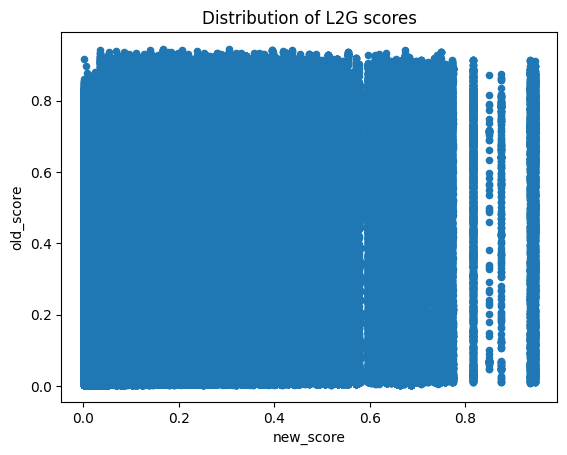

In [30]:
comparison_pdf.plot.scatter(
    x="new_score",
    y="old_score",
    title="Distribution of L2G scores",
)